In [1]:
using SciMLSensitivity
using DifferentialEquations
using SciMLSensitivity   # or DiffEqSensitivity if you prefer
using Zygote
using Optimisers         # for optimizer & update
using LinearAlgebra
using DifferentialEquations
using Flux
using Plots
using Optimization
using OptimizationOptimisers
using Zygote
using DataFrames

using Random
Random.seed!(1234)
println("All the nessecessary packages have been imported")

All the nessecessary packages have been imported


In [2]:

# Hodgkin-Huxley Model Parameters (Global Constants)


# Physical Constants
const Cm = 1.0        # μF/cm^2
const g_Na = 120.0    # mS/cm^2
const g_K = 36.0      # mS/cm^2
const g_L = 0.3       # mS/cm^2
const E_Na = 50.0     # mV
const E_K = -77.0     # mV
const E_L = -54.387   # mV

-54.387

In [3]:
# --- Cell 2: Known Physics & Stimulus ---

# Voltage-gated ion channel kinetics
α_n(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
β_n(V) = 0.125 * exp(-(V + 65) / 80)
α_m(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
β_m(V) = 4.0 * exp(-(V + 65) / 18)
α_h(V) = 0.07 * exp(-(V + 65) / 20)
β_h(V) = 1 / (1 + exp(-(V + 35) / 10))

# Steady-state & time-constant functions for the 2D model
m_inf(V) = α_m(V) / (α_m(V) + β_m(V))
h_inf(V) = α_h(V) / (α_h(V) + β_h(V))
n_inf(V) = α_n(V) / (α_n(V) + β_n(V))
tau_n(V) = 1 / (α_n(V) + β_n(V))

println("Physics of neural dynamics has been defined")



Physics of neural dynamics has been defined


In [4]:
function Stimulus(t)
    # A 1ms pulse starting at 10ms
    return(t>-10.0 && t<11.0) ? 20 : 0.0
end

println(" An extra current form neighbour to generate a pulse")

 An extra current form neighbour to generate a pulse


In [5]:
# --- Cell 3: Data Generation ---

# 2D Hodgkin-Huxley reduced model engine
function hodgkin_huxley_reduced!(du, u, p, t)
    V, n = u
    I_ext = Stimulus(t)


    # Known 2D current
    I_Na = g_Na * m_inf(V)^3 * h_inf(V) * (V - E_Na)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    du[1] = (I_ext - I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end

# Generate Data
u0_true = [-65.0, n_inf(-65.0)]
tspan = (0.0, 50.0)
prob_true = ODEProblem(hodgkin_huxley_reduced!, u0_true, tspan)
sol_true = solve(prob_true, Rodas5P(), saveat=0.5)

# Extract and structure the training data
data_V = sol_true[1, :]
t_train = sol_true.t

# (Optional) Verify data shape and content
df = DataFrame(t=t_train, V=data_V )
println("Generated Training Data:")
display(first(df, 5))

Row,t,V
,Float64,Float64
1,0.0,-65.0
2,0.5,-54.674
3,1.0,-30.723
4,1.5,-22.2061
5,2.0,-31.3453


Generated Training Data:


In [6]:
U = Chain(
    Dense(1,15, tanh,init = Flux.glorot_uniform),
    # Dense(15,30,tanh,init = Flux.glorot_uniform),
    Dense(15,1,init=Flux.glorot_uniform)
)

Chain(
  Dense(1 => 15, tanh),                 # 30 parameters
  Dense(15 => 1),                       # 16 parameters
)                   # Total: 4 arrays, 46 parameters, 392 bytes.

In [7]:
# Extract the trainable parameters (p_nn) and the re-structuring function (re)
p_nn, re = Flux.destructure(U)
println("Recruit Constructed. Parameters: ", length(p_nn))


Recruit Constructed. Parameters: 46


## The hybrid UDE

In [8]:


# Define the UDE function with the embedded neural network
function ude_dynamics!(du, u, p, t)
    V, n = u
    # p --> p_nn neural network parameters
    # Neural network component to learn the unknown current
    # we will normalize V roughly ( divide by 100) to keep inputs clean for the NN

    nn_input = V / 100.0
    # We divide V by 100.0 to keep inputs small for the Neural Network
    # Example: -65mV becomes -0.65

    nn_I_Na = re(p)([nn_input])[1]
    # Known physics components
    I_ext = Stimulus(t)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    
    # The hybrid dynamics equation
    du[1] = (I_ext + nn_I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end
println("Hybrid Engine Assembled.")

Hybrid Engine Assembled.


In [9]:
# ---- Stable predict function using BacksolveAdjoint and Float64 inputs ----



prob_nn = ODEProblem(ude_dynamics!,u0_true,tspan , p_nn)
function predict_ude(p)
    # build problem with the current flattened NN params


    _prob=remake(prob_nn,p=p)
    
    
    solve(_prob, Rodas5P(), saveat=t_train, 
          sensealg=InterpolatingAdjoint(autojacvec=ZygoteVJP()))
end


# ---- Loss function (keep as Float64) ----
function loss(p)
    pred = predict_ude(p)
    if pred.retcode != :Success
        return 1e6
    end
    pred_V = pred[1, :]
    loss_val = sum(abs2, pred_V .- data_V)
    return loss_val
end

println("Objective Functions Defined.")

Objective Functions Defined.


In [10]:

losses=[]
callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Iteration: $(length(losses)) | Loss: $l")
    end
    return false
end

#11 (generic function with 1 method)

In [ ]:

# Define the optimization problem
optf = Optimization.OptimizationFunction((x, p) -> loss(x), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, p_nn)

# Execute the training mission
println("Commencing Training...")
# We use a lower learning rate for stability and more iterations.
# This is a full-scale training run. It may take a few minutes.
res = Optimization.solve(optprob, OptimizationOptimisers.AdamW(0.05, 1e-3), 
                         callback=callback, maxiters=1000)

println("--- TRAINING COMPLETE ---")
println("Training Complete. Final Loss: ", res.objective)

Commencing Training...


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 15, tanh)
│   summary(x) = 1-element Vector{Float64}
└ @ Flux C:\Users\nirbh\.julia\packages\Flux\uRn8o\src\layers\stateless.jl:60


Iteration: 50 | Loss: 2668.708176051515
Iteration: 100 | Loss: 2463.9993205579945
--- TRAINING COMPLETE ---
Training Complete. Final Loss: 2463.5614517208155


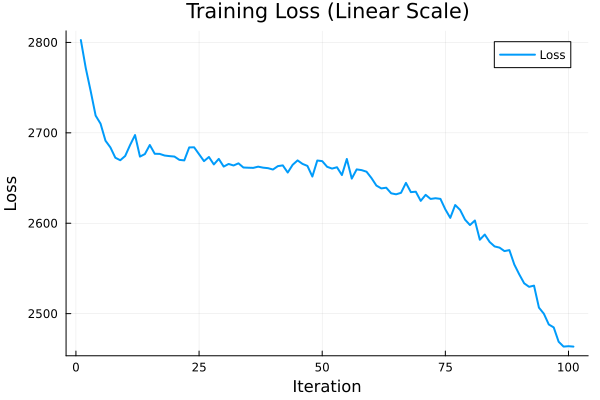

In [12]:
plot(losses,
     xlabel="Iteration",
     ylabel="Loss",
     title="Training Loss (Linear Scale)",
     label="Loss",
     lw=2)


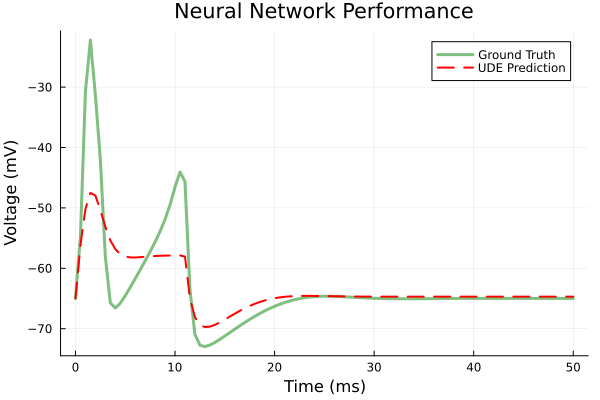

In [13]:
# 2. Visualizing the Recruit vs The Master
# Run a prediction with the TRAINED parameters (res.u)
final_sol = predict_ude(res.u)

p2 = plot(t_train, data_V, label="Ground Truth", lw=3, alpha=0.5, color=:green)
plot!(p2, final_sol.t, final_sol[1,:], label="UDE Prediction", lw=2, color=:red, linestyle=:dash)
title!(p2, "Neural Network Performance")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")
display(p2)